https://github.com/Alokia/diffusion-DDIM-pytorch/tree/master 참고

0. 필요한 모듈 로드

In [ ]:
import torch
import math
import os
from pathlib import Path
from typing import Union, Dict,Optional
from torch.optim import Adam
from torchvision import datasets, transforms
from typing import Optional, Union
from tqdm import tqdm
from torchvision.utils import make_grid
from PIL import Image
from pathlib import Path
import yaml
import os
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from IPython.display import Image, display
from PIL import Image as PILImage

1. MNIST 데이터셋을 위한 DataLoader 생성

In [ ]:
def create_mnist_dataset(data_path, batch_size, **kwargs):


    train = kwargs.get("train", True)
    download = kwargs.get("download", True)


    dataset = MNIST(
        root=data_path,
        train=train,
        download=download,
        transform=transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평으로 뒤집기
            transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
            transforms.Normalize((0.5,), (0.5,))  # 이미지를 평균 0.5, 표준편차 0.5로 정규화
        ])
    )


    loader_params = dict(
        shuffle=kwargs.get("shuffle", True),
        drop_last=kwargs.get("drop_last", True),
        pin_memory=kwargs.get("pin_memory", True),
        num_workers=kwargs.get("num_workers", 4),
    )


    dataloader = DataLoader(dataset, batch_size=batch_size, **loader_params)

    return dataloader

2. U-Net 모델 정의

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import math
from typing import Union, Dict

# times step encoding
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

# GroupNorm 정규화 레이어
def norm_layer(channels):
    return nn.GroupNorm(32, channels)

# TimestepEmbedSequential
class TimestepBlock(nn.Module):
    def forward(self, x, emb):
        raise NotImplementedError

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

# Residual block 정의
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t):
        h = self.conv1(x)
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)

# Attention block 정의
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0
        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B * self.num_heads, -1, H * W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x
# upsampling layer
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if self.use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

# downsampling layer
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if self.use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        return self.op(x)

# UNet
class UNet(nn.Module):
    def __init__(self, in_channels=1, model_channels=128, out_channels=1, num_res_blocks=2, attention_resolutions=(8, 16), dropout=0, channel_mult=(1, 2, 2, 2), conv_resample=True, num_heads=4):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.down_blocks = nn.ModuleList([TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [ResidualBlock(ch + down_block_chans.pop(), model_channels * mult, time_embed_dim, dropout)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.up_blocks:
            h = F.pad(h, (0, hs[-1].size(3) - h.size(3), 0, hs[-1].size(2) - h.size(2)))
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)


3. DDIM 구현

GaussianDiffusionTrainer :
image.png

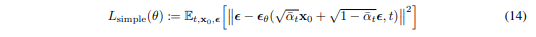

DDIMSampler:

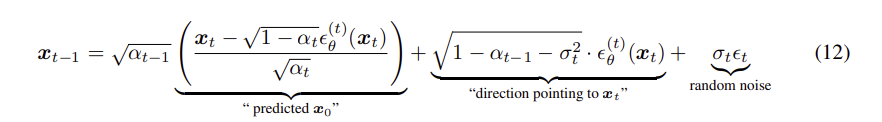

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from typing import Tuple, Union, Dict

def extract(v, i, shape):
    """
    벡터 v에서 인덱스 i에 해당하는 값을 추출합니다.
    v의 shape은 주로 (T, ), i의 shape은 주로 (batch_size, )입니다.
    [v[index] for index in i]와 같습니다.
    """
    out = torch.gather(v, index=i, dim=0)
    out = out.to(device=i.device, dtype=torch.float32)

    # 브로드캐스팅을 위해 (batch_size, 1, 1, 1, 1, ...) 모양으로 변형합니다.
    out = out.view([i.shape[0]] + [1] * (len(shape) - 1))
    return out


class GaussianDiffusionTrainer(nn.Module):
    def __init__(self, model: nn.Module, beta: Tuple[int, int], T: int):
        super().__init__()
        self.model = model
        self.T = T

        # T 단계의 베타 생성
        self.register_buffer("beta_t", torch.linspace(*beta, T, dtype=torch.float32))

        # alpha의 누적 계산
        alpha_t = 1.0 - self.beta_t
        alpha_t_bar = torch.cumprod(alpha_t, dim=0)

        # $q(x_t | x_0)$의 평균, 표준편차  정의
        self.register_buffer("signal_rate", torch.sqrt(alpha_t_bar))
        self.register_buffer("noise_rate", torch.sqrt(1.0 - alpha_t_bar))

    def forward(self, x_0):
        # {1,,,,,T} 얻기
        t = torch.randint(self.T, size=(x_0.shape[0],), device=x_0.device)

        # epsilon N(0, 1)
        epsilon = torch.randn_like(x_0)

        # $x_{t-1}$에서 $x_t$로 추가된 노이즈 예측
        x_t = (extract(self.signal_rate, t, x_0.shape) * x_0 +
               extract(self.noise_rate, t, x_0.shape) * epsilon)

        # 예측한  epsilon 값
        epsilon_theta = self.model(x_t, t)

        # gradient 계산
        loss = F.mse_loss(epsilon_theta, epsilon, reduction="none")
        loss = torch.sum(loss)
        return loss

# class DDPMSampler(nn.Module):
#     def __init__(self, model: nn.Module, beta: Tuple[int, int], T: int):
#         super().__init__()
#         self.model = model
#         self.T = T


#         self.register_buffer("beta_t", torch.linspace(*beta, T, dtype=torch.float32))


#         alpha_t = 1.0 - self.beta_t
#         alpha_t_bar = torch.cumprod(alpha_t, dim=0)
#         alpha_t_bar_prev = F.pad(alpha_t_bar[:-1], (1, 0), value=1.0)

#         self.register_buffer("coeff_1", torch.sqrt(1.0 / alpha_t))
#         self.register_buffer("coeff_2", self.coeff_1 * (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_t_bar))
#         self.register_buffer("posterior_variance", self.beta_t * (1.0 - alpha_t_bar_prev) / (1.0 - alpha_t_bar))

#     @torch.no_grad()
#     def cal_mean_variance(self, x_t, t):
#         epsilon_theta = self.model(x_t, t)
#         mean = extract(self.coeff_1, t, x_t.shape) * x_t - extract(self.coeff_2, t, x_t.shape) * epsilon_theta


#         var = extract(self.posterior_variance, t, x_t.shape)

#         return mean, var

#     @torch.no_grad()
#     def sample_one_step(self, x_t, time_step: int):

#         t = torch.full((x_t.shape[0],), time_step, device=x_t.device, dtype=torch.long)
#         mean, var = self.cal_mean_variance(x_t, t)

#         z = torch.randn_like(x_t) if time_step > 0 else 0
#         x_t_minus_one = mean + torch.sqrt(var) * z

#         if torch.isnan(x_t_minus_one).int().sum() != 0:
#             raise ValueError("텐서에 nan 값이 있습니다!")

#         return x_t_minus_one

#     @torch.no_grad()
#     def forward(self, x_t, only_return_x_0: bool = True, interval: int = 1, **kwargs):

#         x = [x_t]
#         with tqdm(reversed(range(self.T)), colour="#6565b5", total=self.T) as sampling_steps:
#             for time_step in sampling_steps:
#                 x_t = self.sample_one_step(x_t, time_step)

#                 if not only_return_x_0 and ((self.T - time_step) % interval == 0 or time_step == 0):
#                     x.append(torch.clip(x_t, -1.0, 1.0))

#                 sampling_steps.set_postfix(ordered_dict={"step": time_step + 1, "sample": len(x)})

#         if only_return_x_0:
#             return x_t  # [batch_size, channels, height, width]
#         return torch.stack(x, dim=1)  # [batch_size, sample, channels, height, width]

class DDIMSampler(nn.Module):
    def __init__(self, model, beta: Tuple[int, int], T: int):
        super().__init__()
        self.model = model
        self.T = T

        # T 단계의 베타 생성
        beta_t = torch.linspace(*beta, T, dtype=torch.float32)
        # 알파의 누적 곱
        alpha_t = 1.0 - beta_t
        self.register_buffer("alpha_t_bar", torch.cumprod(alpha_t, dim=0))

    @torch.no_grad()
    def sample_one_step(self, x_t, time_step: int, prev_time_step: int, eta: float):
        t = torch.full((x_t.shape[0],), time_step, device=x_t.device, dtype=torch.long)
        prev_t = torch.full((x_t.shape[0],), prev_time_step, device=x_t.device, dtype=torch.long)

        # 현재 및 이전 time step의 누적 알파값
        alpha_t = extract(self.alpha_t_bar, t, x_t.shape)
        alpha_t_prev = extract(self.alpha_t_bar, prev_t, x_t.shape)

        # 모델을 사용하여 노이즈 예측
        epsilon_theta_t = self.model(x_t, t)

        # x_t와 x_0 활용해서 x_{t-1} 계산
        sigma_t = eta * torch.sqrt((1 - alpha_t_prev) / (1 - alpha_t) * (1 - alpha_t / alpha_t_prev)) # DDIM에서 eta=0으로 설정해줌
        epsilon_t = torch.randn_like(x_t)
        x_t_minus_one = (
                torch.sqrt(alpha_t_prev / alpha_t) * x_t +
                (torch.sqrt(1 - alpha_t_prev - sigma_t ** 2) - torch.sqrt(
                    (alpha_t_prev * (1 - alpha_t)) / alpha_t)) * epsilon_theta_t +
                sigma_t * epsilon_t
        )
        return x_t_minus_one

    @torch.no_grad()
    def forward(self, x_t, steps: int = 1, method="linear", eta=0.0,
                only_return_x_0: bool = True, interval: int = 1)
    # T를 S로 어떻게 나눌것인지
        if method == "linear":
          a = self.T // steps
          time_steps = np.asarray(list(range(0, self.T, a)))

        elif method == "quadratic":
            time_steps = (np.linspace(0, np.sqrt(self.T * 0.8), steps) ** 2).astype(np.int)
        else:
            raise NotImplementedError(f"sampling method {method} is not implemented!")

        # 최종 alpha 값을 올바르게 얻기 위해 1을 추가
        time_steps = time_steps + 1
        # 이전 시퀀스
        time_steps_prev = np.concatenate([[0], time_steps[:-1]])

        x = [x_t]
        with tqdm(reversed(range(0, steps)), colour="#6565b5", total=steps) as sampling_steps:
            for i in sampling_steps:
                x_t = self.sample_one_step(x_t, time_steps[i], time_steps_prev[i], eta)

                if not only_return_x_0 and ((steps - i) % interval == 0 or i == 0):
                    x.append(torch.clip(x_t, -1.0, 1.0))

                sampling_steps.set_postfix(ordered_dict={"step": i + 1, "sample": len(x)})

        if only_return_x_0:
            return x_t  # [batch_size, channels, height, width]
        return torch.stack(x, dim=1)  # [batch_size, sample, channels, height, width]

4. Early Stopping & Model checkpoint

In [ ]:
class EarlyStopping:
    def __init__(self, monitor: str = 'val_loss', mode: str = 'min', patience: int = 1):

        self.monitor = monitor
        self.mode = mode
        self.patience = patience
        self.__value = -math.inf if mode == 'max' else math.inf
        self.__times = 0

    def state_dict(self) -> dict:

        return {
            'monitor': self.monitor,
            'mode': self.mode,
            'patience': self.patience,
            'value': self.__value,
            'times': self.__times
        }

    def load_state_dict(self, state_dict: dict):

        self.monitor = state_dict['monitor']
        self.mode = state_dict['mode']
        self.patience = state_dict['patience']
        self.__value = state_dict['value']
        self.__times = state_dict['times']

    def reset(self):

        self.__times = 0

    def step(self, metrics: Union[Dict, int, float]) -> bool:

        if isinstance(metrics, dict):
            metrics = metrics[self.monitor]

        if (self.mode == 'min' and metrics <= self.__value) or (
                self.mode == 'max' and metrics >= self.__value):
            self.__value = metrics
            self.__times = 0
        else:
            self.__times += 1
        if self.__times >= self.patience:
            return True
        return False

class ModelCheckpoint:
    def __init__(self, filepath: str = 'checkpoint.pth', monitor: str = 'val_loss',
                 mode: str = 'min', save_best_only: bool = False, save_freq: int = 1):

        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.mode = mode
        self.save_freq = save_freq
        self.__times = 1
        self.__value = -math.inf if mode == 'max' else math.inf

    @staticmethod
    def save(filepath: str, times: int = None, **kwargs):
        path = Path(filepath)
        if path.is_dir():
            if not path.exists():
                path.mkdir(parents=True)
            path = path.joinpath(f'checkpoint-{times}.pth')
        torch.save(kwargs, str(path))

    def state_dict(self):
        return {
            'filepath': self.filepath,
            'monitor': self.monitor,
            'save_best_only': self.save_best_only,
            'mode': self.mode,
            'save_freq': self.save_freq,
            'times': self.__times,
            'value': self.__value
        }

    def load_state_dict(self, state_dict: dict):
        """
        상태를 로드합니다.
        """
        self.filepath = state_dict['filepath']
        self.monitor = state_dict['monitor']
        self.save_best_only = state_dict['save_best_only']
        self.mode = state_dict['mode']
        self.save_freq = state_dict['save_freq']
        self.__times = state_dict['times']
        self.__value = state_dict['value']

    def reset(self):
        self.__times = 1

    def step(self, metrics: Union[Dict, int, float], **kwargs):

        if isinstance(metrics, dict):
            metrics = metrics[self.monitor]

        flag = False

        if self.save_best_only:
            if (self.mode == 'min' and metrics <= self.__value) or (
                    self.mode == 'max' and metrics >= self.__value):
                self.__value = metrics
                self.save(self.filepath, self.__times, **kwargs)
                flag = True
        else:
            if self.__times % self.save_freq == 0:
                self.save(self.filepath, self.__times, **kwargs)
                flag = True

        self.__times += 1
        return flag


5. 모델의 학습 및 이미지 저장을 위한 Utility 함수

In [ ]:
# YAML 파일을 로드
def load_yaml(yml_path: Union[Path, str], encoding="utf-8"):
    if isinstance(yml_path, str):
        yml_path = Path(yml_path)
    with yml_path.open('r', encoding=encoding) as f:
        cfg = yaml.load(f.read(), Loader=yaml.SafeLoader)
        return cfg

# 한 에포크 동안 훈련하는 함수
def train_one_epoch(trainer, loader, optimizer, device, epoch):
    trainer.train()
    total_loss, total_num = 0., 0

    with tqdm(loader, dynamic_ncols=True, colour="#ff924a") as data:
        for images, _ in data:
            optimizer.zero_grad()

            x_0 = images.to(device)
            loss = trainer(x_0)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_num += x_0.shape[0]

            data.set_description(f"Epoch: {epoch}")
            data.set_postfix(ordered_dict={
                "train_loss": total_loss / total_num,
            })

    return total_loss / total_num

# 이미지를 저장하는 함수
def save_image(images: torch.Tensor, nrow: int = 8, show: bool = True, path: Optional[str] = None,
               format: Optional[str] = None, to_grayscale: bool = False, **kwargs):

    images = images * 0.5 + 0.5
    grid = make_grid(images, nrow=nrow, **kwargs)  # (channels, height, width)
    grid = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()  # (height, width, channels)

    im = Image.fromarray(grid)
    if to_grayscale:
        im = im.convert(mode="L")
    if path is not None:
        im.save(path, format=format)
    if show:
        im.show()
    return grid

# 샘플 이미지를 저장하는 함수
def save_sample_image(images: torch.Tensor, show: bool = True, path: Optional[str] = None,
                      format: Optional[str] = None, to_grayscale: bool = False, **kwargs):

    images = images * 0.5 + 0.5

    grid = []
    for i in range(images.shape[0]):
        # 배치의 각 샘플에 대해 모든 중간 과정 이미지를 한 행에 결합
        t = make_grid(images[i], nrow=images.shape[1], **kwargs)  # (channels, height, width)
        grid.append(t)
    # 모든 결합된 이미지를 텐서로 스택
    grid = torch.stack(grid, dim=0)  # (batch_size, channels, height, width)
    grid = make_grid(grid, nrow=1, **kwargs)  # 모든 배치 이미지를 다른 행에 결합, (channels, height, width)
    grid = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()  # (height, width, channels)

    im = Image.fromarray(grid)
    if to_grayscale:
        im = im.convert(mode="L")
    if path is not None:
        im.save(path, format=format)
    if show:
        im.show()
    return grid

6. Train 함수 정의

In [ ]:
def train(config):
    consume = config["consume"]
    if consume:
        cp = torch.load(config["consume_path"])
        config = cp["config"]
    print(config)

    device = torch.device(config["device"])


    loader = create_mnist_dataset(**config["Dataset"])
    start_epoch = 1

    #
    model = UNet(**config["Model"]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-4)
    trainer = GaussianDiffusionTrainer(model, **config["Trainer"]).to(device)

    checkpoint_dir = os.path.dirname(config["Callback"]["filepath"])
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    =
    model_checkpoint = ModelCheckpoint(**config["Callback"])

    if consume:
        model.load_state_dict(cp["model"])
        optimizer.load_state_dict(cp["optimizer"])
        model_checkpoint.load_state_dict(cp["model_checkpoint"])
        start_epoch = cp["start_epoch"] + 1

    # 학습 루프
    for epoch in range(start_epoch, config["epochs"] + 1):
        loss = train_one_epoch(trainer, loader, optimizer, device, epoch)
        model_checkpoint.step(loss, model=model.state_dict(), config=config,
                              optimizer=optimizer.state_dict(), start_epoch=epoch,
                              model_checkpoint=model_checkpoint.state_dict())

# 설정 파일 로드 및 학습 시작
config = load_yaml("/content/config.yml", encoding="utf-8")
train(config)

{'Model': {'in_channels': 1, 'out_channels': 1, 'model_channels': 128, 'attention_resolutions': [2], 'num_res_blocks': 2, 'dropout': 0.1, 'channel_mult': [1, 2, 2, 2], 'conv_resample': True, 'num_heads': 4}, 'Dataset': {'dataset': ',mnist', 'train': True, 'data_path': './data', 'download': True, 'image_size': [28, 28], 'mode': 'RGB', 'suffix': ['png', 'jpg'], 'batch_size': 64, 'shuffle': True, 'drop_last': True, 'pin_memory': True, 'num_workers': 4}, 'Trainer': {'T': 1000, 'beta': [0.0001, 0.02]}, 'Callback': {'filepath': './checkpoint/mnist.pth', 'save_freq': 1}, 'device': 'cuda:0', 'epochs': 10, 'consume': False, 'consume_path': './checkpoint/mnist10.pth', 'lr': 0.0002}
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2822612.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 494064.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4506887.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 12418858.39it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch: 10: 100%|██████████| 937/937 [06:09<00:00,  2.54it/s, train_loss=18]


7. Sampling

7-1 S=100

In [ ]:
import torch
from PIL import Image
import time


# 설정 변수
checkpoint_path ="/content/checkpoint/mnist.pth" # 체크포인트 경로 설정
device = "cuda"
sampler_type = "ddim"  # "ddpm" 또는 "ddim"
batch_size = 16
result_only = False
interval = 50
eta = 0.0
steps = 100
method = "linear"  # "linear" 또는 "quadratic"
nrow = 4
show = False
image_save_path = "/content/image.png"
to_grayscale = False

@torch.no_grad()
def generate():
    device_torch = torch.device(device)

    cp = torch.load(checkpoint_path)
    # 모델 로드
    model = UNet(**cp["config"]["Model"])
    model.load_state_dict(cp["model"])
    model.to(device_torch)
    model = model.eval()

    if sampler_type == "ddim":
        sampler = DDIMSampler(model, **cp["config"]["Trainer"]).to(device_torch)
    elif sampler_type == "ddpm":
        sampler = DDPMSampler(model, **cp["config"]["Trainer"]).to(device_torch)
    else:
        raise ValueError(f"Unknown sampler: {sampler_type}")

    # 가우시안 노이즈 생성
    z_t = torch.randn((batch_size, cp["config"]["Model"]["in_channels"],
                       *cp["config"]["Dataset"]["image_size"]), device=device_torch)

    extra_param = dict(steps=steps, eta=eta, method=method)
    x = sampler(z_t, only_return_x_0=result_only, interval=interval, **extra_param)

    if result_only:
        save_image(x, nrow=nrow, show=show, path=image_save_path, to_grayscale=to_grayscale)
    else:
        save_sample_image(x, show=show, path=image_save_path, to_grayscale=to_grayscale)

# 시간 측정 시작
start_time = time.time()

# generate 함수 호출
generate()

# 시간 측정 종료
end_time = time.time()

# 소요 시간 출력
print(f"Time taken: {end_time - start_time} seconds")

100%|██████████| 100/100 [00:03<00:00, 25.77it/s, step=1, sample=3]

Time taken: 5.007373571395874 seconds


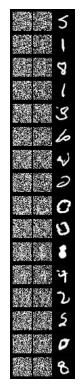

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Correct image path
image_path = "/content/image.png"

# Load and display the image
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()


7-2 S=500

In [ ]:
import torch
from PIL import Image


# 설정 변수
checkpoint_path ="/content/checkpoint/mnist.pth" # 체크포인트 경로 설정
device = "cuda"
sampler_type = "ddim"  # "ddpm" 또는 "ddim"
batch_size = 16
result_only = False
interval = 50
eta = 0.0
steps = 500
method = "linear"  # "linear" 또는 "quadratic"
nrow = 4
show = False
image_save_path = "/content/image_step500.png"
to_grayscale = False

@torch.no_grad()
def generate():
    device_torch = torch.device(device)

    cp = torch.load(checkpoint_path)
    # 모델 로드
    model = UNet(**cp["config"]["Model"])
    model.load_state_dict(cp["model"])
    model.to(device_torch)
    model = model.eval()

    if sampler_type == "ddim":
        sampler = DDIMSampler(model, **cp["config"]["Trainer"]).to(device_torch)
    elif sampler_type == "ddpm":
        sampler = DDPMSampler(model, **cp["config"]["Trainer"]).to(device_torch)
    else:
        raise ValueError(f"Unknown sampler: {sampler_type}")

    # 가우시안 노이즈 생성
    z_t = torch.randn((batch_size, cp["config"]["Model"]["in_channels"],
                       *cp["config"]["Dataset"]["image_size"]), device=device_torch)

    extra_param = dict(steps=steps, eta=eta, method=method)
    x = sampler(z_t, only_return_x_0=result_only, interval=interval, **extra_param)

    if result_only:
        save_image(x, nrow=nrow, show=show, path=image_save_path, to_grayscale=to_grayscale)
    else:
        save_sample_image(x, show=show, path=image_save_path, to_grayscale=to_grayscale)

# 시간 측정 시작
start_time = time.time()

# generate 함수 호출
generate()

# 시간 측정 종료
end_time = time.time()

# 소요 시간 출력
print(f"Time taken: {end_time - start_time} seconds")

100%|██████████| 500/500 [00:19<00:00, 25.77it/s, step=1, sample=11]


Time taken: 20.42222762107849 seconds


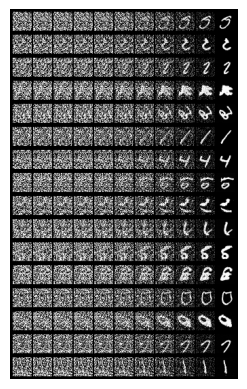

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Correct image path
image_path = "/content/image_step500.png"

# Load and display the image
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()